# Symulacja pracy przychodni

In [128]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

Parametry symulacji

In [ ]:
LAMBDA = 15  # średnia liczba pacjentów na godzinę
CZAS_SYMULACJI = 8 * 60  # symulacja 8 godzin (w minutach)
LEKARZE = 3  # liczba lekarzy
WIELKOSC_KOLEJKI = 10  # maksymalna pojemność kolejki

# Ustawienia czasów wizyt dla poszczególnych lekarzy (w minutach)
CZASY_WIZYT_LEKARZY = [10, 15, 20]
PRIORYTETY = [1, 2, 3] # 1 - najwyższy, 3 - najniższy
ROZKLAD_PRIORYTETÓW = [0.1, 0.2, 0.7] # 1- 10%, 2- 20%, 3- 70%

In [ ]:
# Zmienne pomocnicze
waiting_times_priority_1 = []
waiting_times_priority_2 = []
waiting_times_priority_3 = []

total_patients = 0
waiting_times = []
rejected_patients = 0

time_data = []
queue_data_priority_1 = []
queue_data_priority_2 = []
queue_data_priority_3 = []
total_queue_data = []
in_service_data = []
rejected_data = []

Pacjent 1 (Priorytet 3) przyszedł do przychodni o 08:07 (priorytet: 3).
Pacjent 1 (Priorytet 3) zaczyna wizytę u lekarza 2 o 08:07. Czas oczekiwania: 0.00 minut.
Pacjent 2 (Priorytet 3) przyszedł do przychodni o 08:08 (priorytet: 3).
Pacjent 2 (Priorytet 3) zaczyna wizytę u lekarza 2 o 08:08. Czas oczekiwania: 0.00 minut.
Pacjent 3 (Priorytet 2) przyszedł do przychodni o 08:12 (priorytet: 2).
Pacjent 3 (Priorytet 2) zaczyna wizytę u lekarza 1 o 08:12. Czas oczekiwania: 0.00 minut.
Pacjent 4 (Priorytet 2) przyszedł do przychodni o 08:16 (priorytet: 2).
Pacjent 5 (Priorytet 1) przyszedł do przychodni o 08:17 (priorytet: 1).
Pacjent 1 (Priorytet 3) skończył wizytę o 08:22.
Pacjent 5 (Priorytet 1) zaczyna wizytę u lekarza 3 o 08:22. Czas oczekiwania: 4.92 minut.
Pacjent 3 (Priorytet 2) skończył wizytę o 08:22.
Pacjent 4 (Priorytet 2) zaczyna wizytę u lekarza 1 o 08:22. Czas oczekiwania: 6.61 minut.
Pacjent 2 (Priorytet 3) skończył wizytę o 08:23.
Pacjent 6 (Priorytet 1) przyszedł do przych

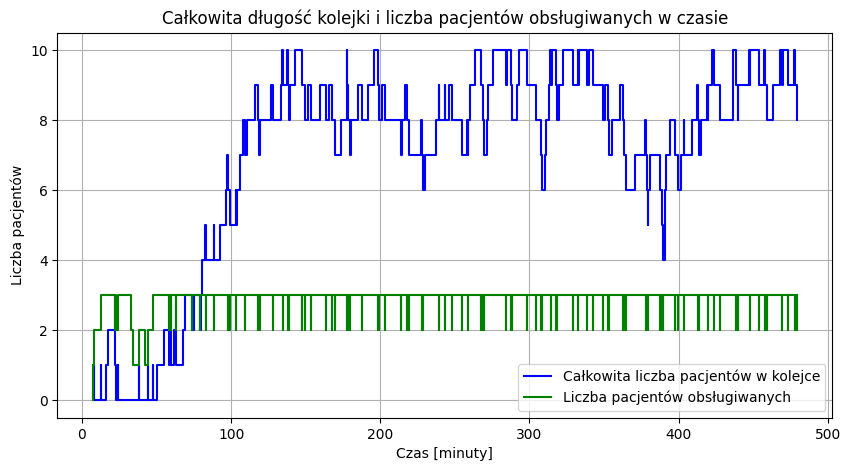

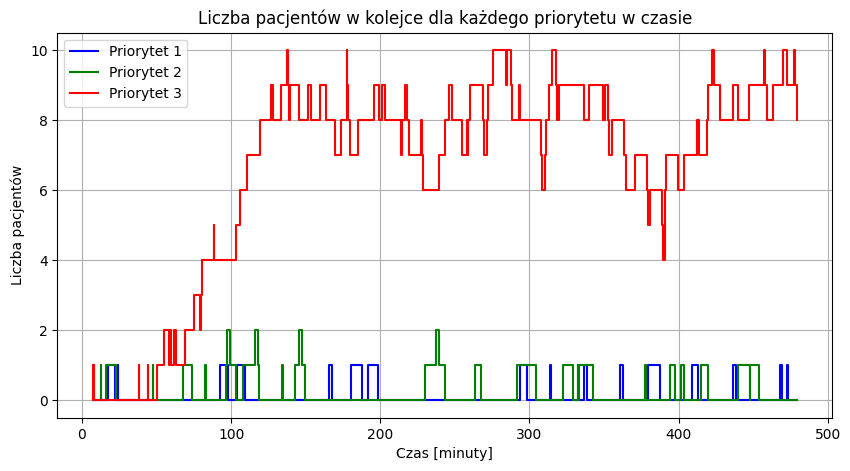

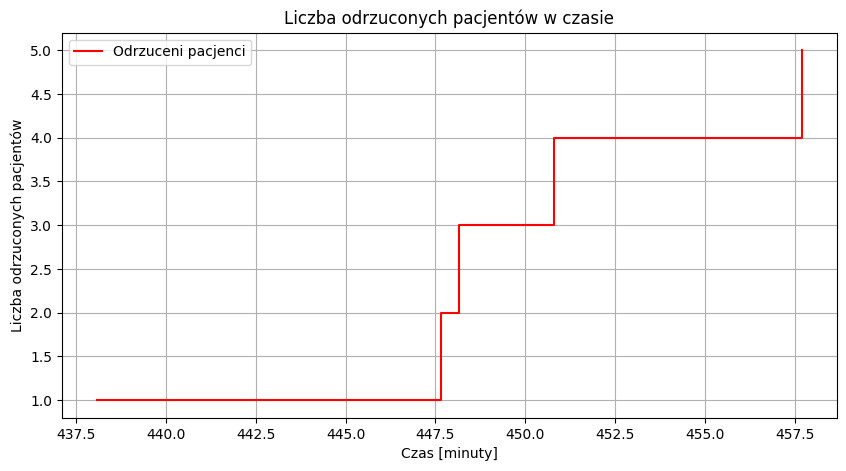

In [ ]:
def format_time(minuty):
    godzina = int(minuty // 60 + 8)
    minuta = int(minuty % 60)
    return f"{godzina:02}:{minuta:02}"

class Przychodnia:
    def __init__(self, env, liczba_lekarzy, czasy_wizyt):
        self.env = env
        self.lekarz = simpy.PriorityResource(env, capacity=liczba_lekarzy)
        self.patients_in_queue = {1: 0, 2: 0, 3: 0}
        self.patients_in_service = 0
        self.czasy_wizyt = czasy_wizyt

    def wizyta(self, pacjent, lekarz_index):
        """Symulacja wizyty pacjenta z różnym czasem trwania dla każdego lekarza"""
        self.patients_in_service += 1
        update_data(self.env.now, self.patients_in_queue, self.patients_in_service) 

        czas_wizyty = self.czasy_wizyt[lekarz_index]
        yield self.env.timeout(czas_wizyty)

        self.patients_in_service -= 1
        update_data(self.env.now, self.patients_in_queue, self.patients_in_service)
        print(f"{pacjent['name']} skończył wizytę o {format_time(self.env.now)}.")

def pacjent(env, name, przychodnia, priorytet):
    global total_patients, rejected_patients
    arrival_time = env.now

    if sum(przychodnia.patients_in_queue.values()) >= WIELKOSC_KOLEJKI:
        if priorytet < 3 and przychodnia.patients_in_queue[3] > 0:
            if przychodnia.patients_in_queue[3] > 0:
                przychodnia.patients_in_queue[3] -= 1
                print(f"Pacjent o priorytecie 3 został usunięty z kolejki, aby zrobić miejsce dla {name} (Priorytet {priorytet}).")
        elif priorytet < 2 and przychodnia.patients_in_queue[2] > 0:
            if przychodnia.patients_in_queue[2] > 0:
                przychodnia.patients_in_queue[2] -= 1
                print(f"Pacjent o priorytecie 2 został usunięty z kolejki, aby zrobić miejsce dla {name} (Priorytet {priorytet}).")
        else:
            queue_status = f"Priorytet 1: {przychodnia.patients_in_queue[1]}, Priorytet 2: {przychodnia.patients_in_queue[2]}, Priorytet 3: {przychodnia.patients_in_queue[3]}"
            print(f"{name} (Priorytet {priorytet}) został odrzucony o {format_time(arrival_time)} z powodu pełnej kolejki. Stan kolejki: {queue_status}.")
            rejected_patients += 1
            rejected_data.append((env.now, rejected_patients))
            return

    print(f"{name} przyszedł do przychodni o {format_time(arrival_time)} (priorytet: {priorytet}).")
    przychodnia.patients_in_queue[priorytet] += 1
    update_data(env.now, przychodnia.patients_in_queue, przychodnia.patients_in_service)

    with przychodnia.lekarz.request(priority=priorytet) as request:
        yield request
        przychodnia.patients_in_queue[priorytet] -= 1
        waiting_time = env.now - arrival_time
        waiting_times.append(waiting_time)

        if priorytet == 1:
            waiting_times_priority_1.append(waiting_time)
        elif priorytet == 2:
            waiting_times_priority_2.append(waiting_time)
        else:
            waiting_times_priority_3.append(waiting_time)

        lekarz_index = random.randint(0, len(przychodnia.czasy_wizyt) - 1)
        print(f"{name} zaczyna wizytę u lekarza {lekarz_index + 1} o {format_time(env.now)}. Czas oczekiwania: {waiting_time:.2f} minut.")

        yield env.process(przychodnia.wizyta({'name': name}, lekarz_index))
        total_patients += 1


def proces_nadejscia(env, przychodnia):
    """Generowanie pacjentów zgodnie z procesem Poissona"""
    i = 0
    while True:
        czas_nastepnego = random.expovariate(LAMBDA / 60)
        yield env.timeout(czas_nastepnego)
        i += 1

        priorytet = random.choices(PRIORYTETY, weights=ROZKLAD_PRIORYTETÓW)[0]
        name = f"Pacjent {i} (Priorytet {priorytet})"

        env.process(pacjent(env, name, przychodnia, priorytet))

def update_data(time, patients_in_queue, patients_in_service):
    """Funkcja do aktualizacji danych do wykresów"""
    time_data.append(time)
    queue_data_priority_1.append(patients_in_queue[1])
    queue_data_priority_2.append(patients_in_queue[2])
    queue_data_priority_3.append(patients_in_queue[3])
    total_queue_data.append(sum(patients_in_queue.values()))
    in_service_data.append(patients_in_service)

def run_simulation():
    global total_patients, waiting_times, rejected_patients
    env = simpy.Environment()
    przychodnia = Przychodnia(env, LEKARZE, CZASY_WIZYT_LEKARZY)

    env.process(proces_nadejscia(env, przychodnia))

    env.run(until=CZAS_SYMULACJI)

    print("\nSymulacja zakończona.")
    print(f"Liczba obsłużonych pacjentów: {total_patients}")
    print(f"Liczba odrzuconych pacjentów: {rejected_patients}")
    if waiting_times:
        print(f"Średni czas oczekiwania: {np.mean(waiting_times):.2f} minut")
    else:
        print("Nie było żadnych pacjentów w kolejce.")

if __name__ == "__main__":
    run_simulation()

    # Wykres 1: Całkowita liczba pacjentów w kolejce i liczba pacjentów obsługiwanych
    plt.figure(figsize=(10, 5))
    plt.step(time_data, total_queue_data, label='Całkowita liczba pacjentów w kolejce', color='blue', where='post')
    plt.step(time_data, in_service_data, label='Liczba pacjentów obsługiwanych', color='green', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba pacjentów")
    plt.title("Całkowita długość kolejki i liczba pacjentów obsługiwanych w czasie")
    plt.legend()
    plt.grid()
    plt.show()

    # Wykres 2: Liczba pacjentów w kolejce dla każdego priorytetu
    plt.figure(figsize=(10, 5))
    plt.step(time_data, queue_data_priority_1, label='Priorytet 1', color='blue', where='post')
    plt.step(time_data, queue_data_priority_2, label='Priorytet 2', color='green', where='post')
    plt.step(time_data, queue_data_priority_3, label='Priorytet 3', color='red', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba pacjentów")
    plt.title("Liczba pacjentów w kolejce dla każdego priorytetu w czasie")
    plt.legend()
    plt.grid()
    plt.show()


    # Wykres 3: Liczba odrzuconych pacjentów w czasie
    rejected_times, rejected_counts = zip(*rejected_data) if rejected_data else ([], [])
    plt.figure(figsize=(10, 5))
    plt.step(rejected_times, rejected_counts, label='Odrzuceni pacjenci', color='red', where='post')
    plt.xlabel("Czas [minuty]")
    plt.ylabel("Liczba odrzuconych pacjentów")
    plt.title("Liczba odrzuconych pacjentów w czasie")
    plt.legend()
    plt.grid()
    plt.show()
